In [1]:
import geopandas
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:

# load LA neighborhood geo data
geojson_file_loc = "data/mapping-la-data-main/geojson/la-county-neighborhoods-v6.geojson"
geo_la_neighborhood = geopandas.read_file(geojson_file_loc)
# LA EPSG transformation
# geo_la_neighborhood = geo_la_neighborhood.to_crs('EPSG:3395')
geo_la_neighborhood["area"] = geo_la_neighborhood.area
geo_la_neighborhood['boundary'] = geo_la_neighborhood.boundary
geo_la_neighborhood['centroid'] = geo_la_neighborhood.centroid
# load LA neighborhood poplulation data
pop_la_neighborhood = pd.read_csv('data/la-neighborhood-population.csv')
# merge two dataframe together
df = geo_la_neighborhood.merge(pop_la_neighborhood, left_on='name', right_on='Neighborhood', how='inner')
del df['Neighborhood']
del df['kind']
del df['external_id']
del df['slug']
del df['set']
del df['metadata']
del df['resource_uri']
df = df.rename(columns={'Population per Sqmi':'pop_density'})
df['pop'] = round(df['pop_density'] * df['area'] * 2000 *2.25)

C:\Users\guanc\AppData\Local\Temp\ipykernel_22364\3971442771.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_la_neighborhood["area"] = geo_la_neighborhood.area
C:\Users\guanc\AppData\Local\Temp\ipykernel_22364\3971442771.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_la_neighborhood['centroid'] = geo_la_neighborhood.centroid


In [3]:
# load LA existing vertiport data
df_heliport = pd.read_csv('data/us-heliports-landing-facilities.csv')
del df_heliport['State_Name']
del df_heliport['Facility_Type']
del df_heliport['County_s_State_Post_Office_Code']
df_airport = pd.read_csv('data/us-general-aviation-airports.csv')
del df_airport['County_s_State_Post_Office_Code']
del df_airport['State_Name']
df_vertiport = pd.concat([df_heliport, df_airport])
mask = (df_vertiport['SHAPE_X'] <-117.6) & (df_vertiport['SHAPE_X'] > -119) & (df_vertiport['SHAPE_Y'] <34.8) & (df_vertiport['SHAPE_Y'] > 33.6)
df_vertiport_la = df_vertiport[mask]

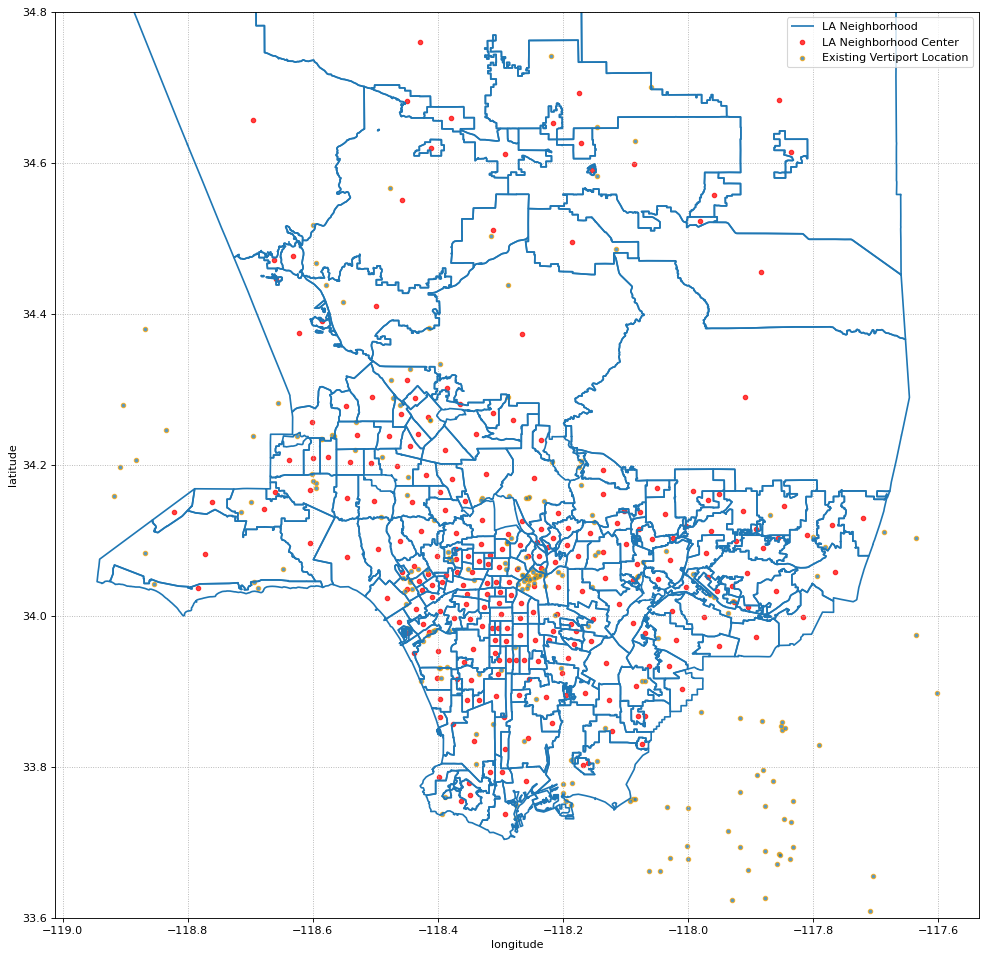

In [14]:

fig, ax = plt.subplots(figsize=(15,15), dpi=80)
df.plot(ax=ax, label='LA Neighborhood')
c = geopandas.GeoDataFrame(df, geometry=df['centroid'])
c.plot(ax=ax, color='red',alpha=0.75, markersize=16, label='LA Neighborhood Center')
ax.scatter(df_vertiport_la['SHAPE_X'], df_vertiport_la['SHAPE_Y'], s=16, edgecolors='orange', alpha=0.75, label='Existing Vertiport Location')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_ylim(33.6, 34.8)
ax.legend()
ax.grid(linestyle=':')
plt.savefig('proj01.png')

In [28]:
from scipy.sparse import csr_matrix
df_centroid = pd.DataFrame(df[['name','centroid','pop']])
n = len(df_centroid)
df_centroid['idx'] = df_centroid.index
# Cartesian product to calculate distance between all centroid pairs
centroid_pair = df_centroid.merge(df_centroid, how='cross')
centroid_pair['distance']=centroid_pair.apply(lambda x: x['centroid_x'].distance(x['centroid_y']), axis=1)
centroid_pair['total_pop']=centroid_pair.apply(lambda x: x['pop_x'] + x['pop_y'], axis=1)
# distance matrix
D = csr_matrix((centroid_pair['distance'], (centroid_pair['idx_x'], centroid_pair['idx_y'])), shape=(n,n))
# population matrix
P = csr_matrix((centroid_pair['total_pop'], (centroid_pair['idx_x'], centroid_pair['idx_y'])), shape=(n,n))
P = P / np.max(P)


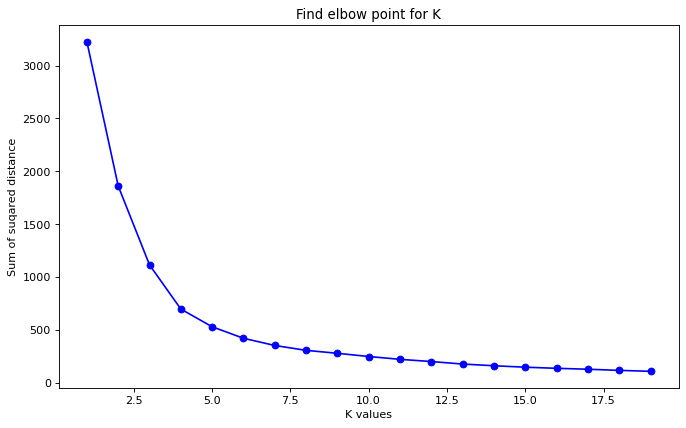

In [31]:
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
embedding = Isomap(n_neighbors=10,n_components=2)
D_transformed = embedding.fit_transform(D)

sum_of_squared_distiance=[]
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(D_transformed)
    sum_of_squared_distiance.append(kmeans.inertia_)
fig, ax = plt.subplots(1,1,figsize=(10,6), dpi=80)
ax.plot(K,sum_of_squared_distiance,'bo-')
ax.set_xlabel('K values')
ax.set_ylabel('Sum of suqared distance')
ax.set_title('Find elbow point for K')
plt.savefig('proj02.png')

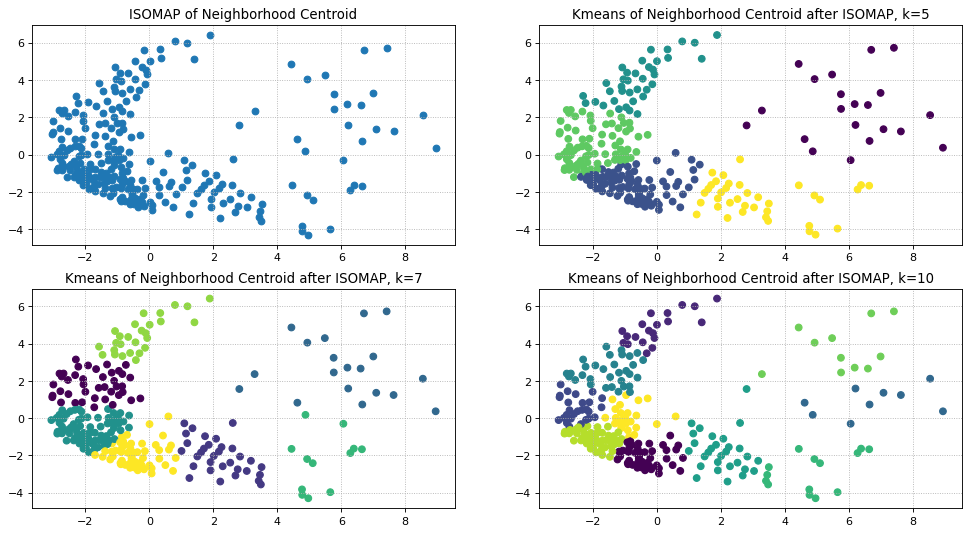

In [32]:


fig, ax = plt.subplots(2,2,figsize=(15,8), dpi=80)
ax[0,0].scatter(D_transformed[:,0], D_transformed[:,1])
ax[0,0].set_title('ISOMAP of Neighborhood Centroid')
ax[0,0].grid(linestyle=':')

kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(D_transformed)
kmeans_7 = KMeans(n_clusters=7, random_state=0).fit(D_transformed)
kmeans_10 = KMeans(n_clusters=10, random_state=0).fit(D_transformed)
ax[0,1].scatter(D_transformed[:,0], D_transformed[:,1], c=kmeans_5.labels_)
ax[0,1].set_title('Kmeans of Neighborhood Centroid after ISOMAP, k=5')
ax[0,1].grid(linestyle=':')
ax[1,0].scatter(D_transformed[:,0], D_transformed[:,1], c=kmeans_7.labels_)
ax[1,0].set_title('Kmeans of Neighborhood Centroid after ISOMAP, k=7')
ax[1,0].grid(linestyle=':')
ax[1,1].scatter(D_transformed[:,0], D_transformed[:,1], c=kmeans_10.labels_)
ax[1,1].set_title('Kmeans of Neighborhood Centroid after ISOMAP, k=10')
ax[1,1].grid(linestyle=':')
plt.savefig('proj03.png')

C:\Users\guanc\AppData\Local\Temp\ipykernel_22364\1600871487.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_dissolve['centroid'] = df_dissolve.centroid


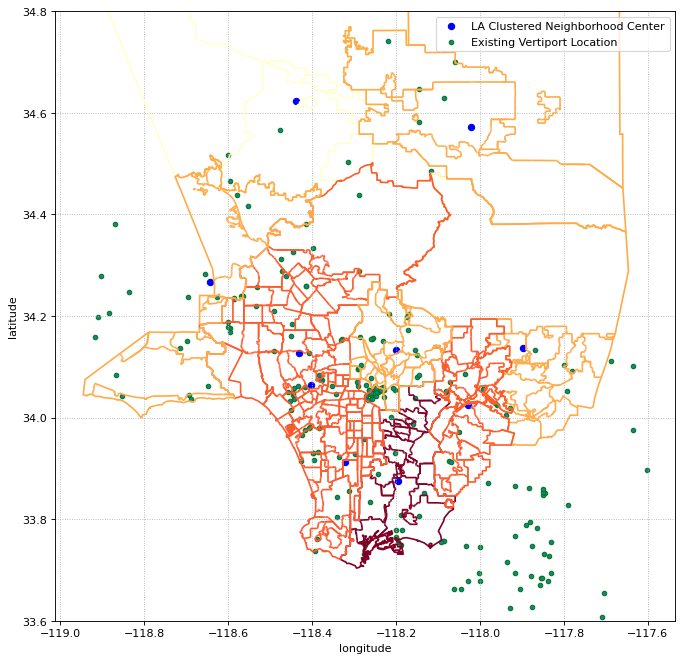

In [35]:
df['label']=kmeans_10.labels_

df_pre_dissolve = geopandas.GeoDataFrame(df, geometry=df['boundary'])
df_dissolve = df[['geometry', 'pop', 'label']].dissolve(by='label', aggfunc='sum')
# df_dissolve = df_dissolve.to_crs('EPSG:3395')
df_dissolve['centroid'] = df_dissolve.centroid

fig, ax = plt.subplots(figsize=(10,15), dpi=80)
df_dissolve.plot(ax=ax,column = 'pop', scheme='Percentiles', cmap='YlOrRd')
df_dissolve_c = geopandas.GeoDataFrame(df_dissolve)
df_dissolve_c['geometry'] = df_dissolve_c['centroid']
df_dissolve_c.plot(ax=ax, color='blue', markersize=32, label='LA Clustered Neighborhood Center')
ax.scatter(df_vertiport_la['SHAPE_X'], df_vertiport_la['SHAPE_Y'], s=16, edgecolors='green', label='Existing Vertiport Location')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_ylim(33.6,34.8)
ax.legend()
ax.grid(linestyle=':')
plt.savefig('proj04.png')

Now we will try to balance population density with average commute times. Let's start by taking a look at the commute profiles of different cities around LA.

In [37]:
import re
import os
import datetime
from datetime import datetime
import seaborn as sns
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

In [38]:
workdir = os.getcwd()
average_travel_file = "\data\Average Travel time by departure time.xlsx"
path = os.path.join(workdir+average_travel_file)

avg_commute = pd.read_excel(path,header = 4)
avg_commute.fillna(0)

def clean_locations(string):
    return re.findall("(?<=--)(.*)(?= PUMA)",string)[0]


avg_commute['Selected Geographies'] = avg_commute['Selected Geographies'].apply(lambda x: clean_locations(x))

drop_col = avg_commute.columns[1]

avg_commute.drop([drop_col],axis=1,inplace=True)
avg_commute.fillna(np.NaN,inplace=True)
avg_commute

,Selected Geographies,12:00 a.m. to 12:29 a.m.,12:30 a.m. to 12:59 a.m.,1:00 a.m. to 1:29 a.m.,1:30 a.m. to 1:59 a.m.,2:00 a.m. to 2:29 a.m.,2:30 a.m. to 2:59 a.m.,3:00 a.m. to 3:09 a.m.,3:10 a.m. to 3:19 a.m.,3:20 a.m. to 3:29 a.m.,...,9:40 p.m. to 9:49 p.m.,9:50 p.m. to 9:59 p.m.,10:00 p.m. to 10:09 p.m.,10:10 p.m. to 10:19 p.m.,10:20 p.m. to 10:29 p.m.,10:30 p.m. to 10:39 p.m.,10:40 p.m. to 10:49 p.m.,10:50 p.m. to 10:59 p.m.,11:00 p.m. to 11:29 p.m.,11:30 p.m. to 11:59 p.m.
0,Castaic,45.0,NaN,12.0,NaN,60.0,124.0,47.0,NaN,NaN,...,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Santa Clarita City,142.0,NaN,85.0,NaN,58.0,NaN,29.0,NaN,NaN,...,NaN,30.0,17.0,NaN,NaN,35.0,NaN,NaN,30.0,15.0
2,Lancaster City,NaN,45.0,NaN,60.0,NaN,NaN,91.0,12.0,NaN,...,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,50.0,15.0
3,Palmdale City,10.0,50.0,NaN,90.0,57.0,15.0,83.0,NaN,62.0,...,NaN,NaN,45.0,NaN,80.0,NaN,NaN,NaN,142.0,20.0
4,LA City (Northwest/Chatsworth & Porter Ranch),15.0,10.0,NaN,40.0,NaN,NaN,38.0,NaN,NaN,...,NaN,NaN,15.0,NaN,40.0,29.0,10.0,NaN,11.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Long Beach City (East),19.0,35.0,NaN,105.0,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN
65,Long Beach City (Southwest & Port),NaN,NaN,18.0,NaN,142.0,NaN,NaN,17.0,NaN,...,NaN,NaN,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,LA City (South/San Pedro),15.0,NaN,20.0,15.0,30.0,30.0,31.0,NaN,16.0,...,NaN,NaN,15.0,NaN,NaN,30.0,7.0,5.0,20.0,5.0
67,Palos Verdes Peninsula,NaN,NaN,NaN,83.0,NaN,10.0,14.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
def clean_time(string):
    temp = re.findall("[\d]{1,2}:[\d]{2}[\s][\w][.][\w][.]",string)[0]
    time = temp.split(" ")
    time[1] = time[1].upper().replace(".","")
    stringy = " ".join(time)
    return stringy

just_time = avg_commute.drop(['Selected Geographies'],axis=1)

old_cols = list(just_time.columns.values)
new_cols = pd.Series(old_cols).apply(lambda x: clean_time(x))
new_cols = pd.to_datetime(new_cols, format="%I:%M %p").dt.strftime('%H:%M')
just_time.set_axis(new_cols,axis=1,inplace= True)

avg_T = just_time.transpose().set_axis(avg_commute['Selected Geographies'], axis=1)
avg_T.index = pd.to_datetime(avg_T.index)
avg_T = avg_T.resample('10T').sum()
avg_T.index = pd.to_datetime(avg_T.index).strftime('%H:%M')

c:\Users\guanc\anaconda3\envs\my-geopandas-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


87600.35210944698

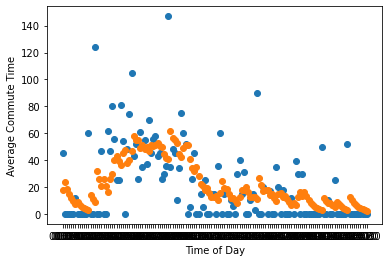

In [40]:
plt.scatter(avg_T.index,avg_T['Castaic'])
fit1 = SimpleExpSmoothing(avg_T['Castaic'], initialization_method="heuristic").fit(smoothing_level=0.2, optimized=False)
plt.scatter(avg_T.index,fit1.fittedvalues)
plt.ylabel('Average Commute Time')
plt.xlabel('Time of Day')
plt.plot()
fit1.sse

c:\Users\guanc\anaconda3\envs\my-geopandas-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


104648.58714051798

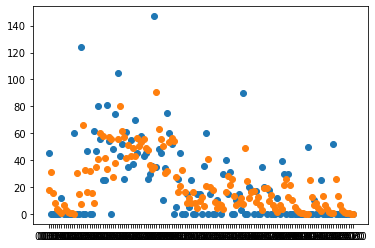

In [41]:
plt.scatter(avg_T.index,avg_T['Castaic'])
fit2 = SimpleExpSmoothing(avg_T['Castaic'], initialization_method="heuristic").fit(smoothing_level=0.5, optimized=False)
plt.scatter(avg_T.index,fit2.fittedvalues)
plt.plot()
fit2.sse

c:\Users\guanc\anaconda3\envs\my-geopandas-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


130105.90989705811

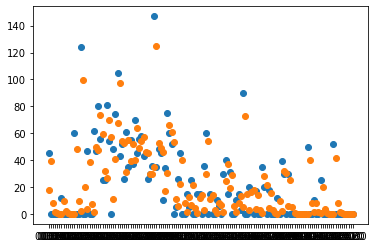

In [42]:

plt.scatter(avg_T.index,avg_T['Castaic'])
fit3 = SimpleExpSmoothing(avg_T['Castaic'], initialization_method="heuristic").fit(smoothing_level=0.8, optimized=False)
plt.scatter(avg_T.index,fit3.fittedvalues)
plt.plot()
fit3.sse

In [43]:
smoothed_commutes = avg_T.apply(lambda x: SimpleExpSmoothing(x, initialization_method="heuristic").fit(smoothing_level=0.2, optimized=False).fittedvalues)
smoothed_commutes

c:\Users\guanc\anaconda3\envs\my-geopandas-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
c:\Users\guanc\anaconda3\envs\my-geopandas-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
c:\Users\guanc\anaconda3\envs\my-geopandas-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
c:\Users\guanc\anaconda3\envs\my-geopandas-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
c:\Users\guanc\anaconda3\envs\my-geopandas-env\lib\site-packages\statsmodels\tsa\bas

Selected Geographies,Castaic,Santa Clarita City,Lancaster City,Palmdale City,LA City (Northwest/Chatsworth & Porter Ranch),LA City (North Central/Granada Hills & Sylmar),LA (North Central/Arleta & Pacoima) & San Fernando Cities,"LA City (Northeast/Sunland, Sun Valley & Tujunga)",San Gabriel Valley Region (North),"Baldwin Park, Azusa, Duarte & Irwindale Cities",...,"Redondo Beach, Manhattan Beach & Hermosa Beach Cities",Torrance City,Carson City,Long Beach City (North),"Lakewood, Cerritos, Artesia & Hawaiian Gardens Cities",Long Beach City (East),Long Beach City (Southwest & Port),LA City (South/San Pedro),Palos Verdes Peninsula,Long Beach (Central) & Signal Hill Cities
00:00,18.000000,56.800000,-3.000000,-4.000000,3.108624e-15,16.000000,4.000000,12.800000,27.200000,-11.200000,...,3.200000,6.600000,9.600000,2.200000,26.800000,-6.400000,-3.903128e-17,3.000000,-16.600000,0.000000
00:10,23.400000,73.840000,-2.400000,-1.200000,3.000000e+00,20.800000,5.200000,16.640000,35.360000,-4.960000,...,4.160000,5.480000,12.480000,4.560000,34.840000,-1.320000,-3.122502e-17,5.400000,-13.280000,0.000000
00:20,18.720000,59.072000,-1.920000,-0.960000,2.400000e+00,16.640000,4.160000,13.312000,28.288000,-3.968000,...,3.328000,4.384000,9.984000,3.648000,27.872000,-1.056000,-2.498002e-17,4.320000,-10.624000,0.000000
00:30,14.976000,47.257600,-1.536000,-0.768000,1.920000e+00,13.312000,3.328000,10.649600,22.630400,-3.174400,...,2.662400,3.507200,7.987200,2.918400,22.297600,-0.844800,-1.998401e-17,3.456000,-8.499200,0.000000
00:40,11.980800,37.806080,7.771200,9.385600,3.536000e+00,10.649600,2.662400,8.519680,18.104320,6.660480,...,2.129920,9.005760,6.389760,9.334720,17.838080,6.324160,-1.598721e-17,2.764800,-6.799360,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:50,5.250272,9.632710,6.122635,15.976156,1.372067e+01,0.325386,7.901443,5.973203,3.674976,11.828378,...,9.552510,3.920207,3.449782,14.131340,9.715488,0.081746,7.362307e+00,8.119711,2.122020,2.315545
23:00,4.200218,7.706168,4.898108,12.780925,1.097654e+01,0.260309,6.321155,4.778562,2.939981,9.462702,...,7.642008,3.136166,2.759826,26.305072,7.772391,0.065397,5.889845e+00,7.495769,1.697616,1.852436
23:10,3.360174,12.164935,13.918486,38.624740,1.098123e+01,5.208247,11.856924,3.822850,2.351985,7.570162,...,8.113607,2.508932,6.407861,25.844058,9.817913,7.652317,4.711876e+00,9.996615,1.358093,1.481949
23:20,2.688139,9.731948,11.134789,30.899792,8.784984e+00,4.166598,9.485539,3.058280,1.881588,6.056129,...,6.490885,2.007146,5.126288,20.675246,7.854330,6.121854,3.769501e+00,7.997292,1.086474,1.185559


In [ ]:
morning = smoothed_commutes.loc["04:00":"12:00"]
morning

Selected Geographies,Castaic,Santa Clarita City,Lancaster City,Palmdale City,LA City (Northwest/Chatsworth & Porter Ranch),LA City (North Central/Granada Hills & Sylmar),LA (North Central/Arleta & Pacoima) & San Fernando Cities,"LA City (Northeast/Sunland, Sun Valley & Tujunga)",San Gabriel Valley Region (North),"Baldwin Park, Azusa, Duarte & Irwindale Cities",...,"Redondo Beach, Manhattan Beach & Hermosa Beach Cities",Torrance City,Carson City,Long Beach City (North),"Lakewood, Cerritos, Artesia & Hawaiian Gardens Cities",Long Beach City (East),Long Beach City (Southwest & Port),LA City (South/San Pedro),Palos Verdes Peninsula,Long Beach (Central) & Signal Hill Cities
04:00,39.919906,9.475657,48.348177,48.170714,10.946979,16.165318,10.671512,5.940597,10.549129,7.986596,...,2.280556,2.515323,10.994472,11.940310,9.222086,11.788502,9.545246,11.877934,1.904733,2.200249
04:10,43.135925,14.180525,50.478542,51.936571,15.757583,21.932255,18.937209,10.352477,31.439303,14.589277,...,6.024445,6.612259,17.395578,13.752248,14.977669,16.230802,13.836197,15.302348,5.323786,6.360199
04:20,39.508740,11.344420,40.382834,44.549257,12.606067,23.345804,18.149767,13.281982,33.151443,17.271421,...,4.819556,7.289807,17.916462,11.001798,14.982135,21.984642,11.068958,12.241878,13.259029,14.088159
04:30,36.606992,18.675536,37.706267,35.639406,10.084853,18.676643,14.519814,10.625586,26.521154,19.817137,...,8.855645,8.231846,16.333170,8.801439,11.985708,17.587713,8.855166,15.793502,10.607223,11.270527
04:40,45.485594,22.740429,42.165013,34.911524,18.467883,20.341314,20.615851,13.900468,28.216923,22.453710,...,10.484516,14.785476,16.266536,10.641151,17.988567,31.070171,14.284133,20.634802,15.485779,13.016422
04:50,47.188475,28.792343,35.332011,42.129220,32.774306,18.273052,21.292681,17.120375,22.573539,24.962968,...,16.387613,11.828381,18.013229,10.912921,19.790853,34.056136,11.427306,34.907842,19.388623,10.413138
05:00,37.750780,32.033875,41.865609,44.303376,26.219445,14.618441,17.034145,13.696300,18.058831,25.570374,...,13.110090,11.062705,14.410583,8.730337,22.632683,31.644909,9.141845,27.926273,15.510898,8.330510
05:10,39.800624,35.227100,44.892487,47.842701,28.575556,20.494753,23.627316,27.557040,22.247065,26.456299,...,17.888072,14.850164,16.128466,12.984269,25.306146,32.915927,15.313476,37.141019,19.808719,14.664408
05:20,46.640499,45.981680,51.113990,58.074160,28.460445,23.395802,26.501853,38.045632,25.597652,37.765039,...,30.310458,11.880131,19.102773,18.787415,32.044917,47.332742,37.250781,44.912815,17.446975,21.731526
05:30,58.312399,61.785344,72.291192,50.459328,22.768356,25.716642,21.801482,41.036505,27.478121,39.812032,...,24.248366,9.504105,24.482218,31.029932,35.235933,57.866193,47.800625,44.930252,13.957580,22.585221


In [ ]:
import geopy
from geopy.geocoders import GeoNames
gn = GeoNames(username='matthew.rand')

Come back here and break up the neighborhoods. Assign them Lat/long and do a nearest neighbor analysis to determine how to match commute data with population data.

In [ ]:
commute_statistics = pd.DataFrame(smoothed_commutes.columns)
commute_statistics['Average Commute'] = commute_statistics['Selected Geographies'].apply(lambda x: np.mean(morning[x]))
commute_statistics['Variation in Commute Time'] = commute_statistics['Selected Geographies'].apply(lambda x: np.std(morning[x]))
commute_statistics['Centroid'] = commute_statistics['Selected Geographies'].apply(lambda x: gn.geocode("{} CA USA".format(x))[1][::-1]  )

commute_statistics

TypeError: 'NoneType' object is not subscriptable

In [ ]:
for city in commute_statistics['Selected Geographies']:
    locale = "{} California USA".format(city)
    print(gn.geocode(locale)[1][::-1])

(-118.62287, 34.48888)
(-118.50352, 34.4119)
(-118.17524, 34.69344)
(-118.10579, 34.59448)


TypeError: 'NoneType' object is not subscriptable